# Hovercraft Path Planning 
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
## Problem Statement and Model
------------------------------------------------------------------------------------------------
In this case study, we seek to determine an optimal control policy for the trajectory of a hovercraft that travels to a set of dynamic waypoints $p$ while trying to minimize the thrust input $u$. Let's model this problem using a point mass Newtonian equations (assuming the mass to be 1):
$$ \frac{dx(t)}{dt} = v(t) $$
$$ \frac{dv(t)}{dt} = u(t). $$
 
Here $x(t)$ is the Cartesian position and $v(t)$ is the velocity. 

With this model we can now formulate a dynamic optimization problem that minimizes the necessary thrust to reach all of our waypoints at the alotted times in a time horizon $T$:
$$
\begin{aligned}
	&&\underset{x(t), v(t), u(t)}{\text{min}} &&& \int_{t \in T} \sum_{i \in I} u_i^2(t) dt  \\
	&&\text{s.t.} &&& v_i(0) = v0_i, && \forall i \in I\\
	&&&&& \frac{dx_i(t)}{dt} = v_i(t), && \forall i \in I\\
    &&&&& \frac{dv_i(t)}{dt} = u_i(t), && \forall i \in I\\
    &&&&& x_i(t_w) = p_{iw}, && \forall i \in I, w \in W.
\end{aligned}
$$

## Modeling Preliminaries
--------------------------------------------------------------------------------------------------
Now let's model this using InfiniteOpt.jl! We'll get started by loading in the needed packages and by specifiying our desired problem parameters.

In [2]:
using InfiniteOpt, JuMP, Ipopt, Plots

In [3]:
# Specify waypoint information
p = [1 4 6 1; 1 3 0 1] # positions
tw = [0, 25, 50, 60]    # times

# Specify the problem sets 
I = 1:2 # cartesian indices
W = 1:4 # waypoint indices

# Specify the time horizon parameters 
t0 = 0
tf = 60

# Specify the initial condition values 
v0 = [0, 0];

## Model Initialization
---------------------------------------------------------------------------------------------------
Now let's setup our infinite model and select Ipopt as our optimizer that will be used to solve it. This is accomplished using `InfiniteModel`.

In [4]:
model = InfiniteModel(Ipopt.Optimizer);

## Parameter & Variable Definition
---------------------------------------------------------------------------------------------------
We have a model now, so let's add our infinite parameters and decision variables. In this problem, we have 1 infinite parameter $t \in T = [t_0, t_f]$ and 3 decision variables: 
* $x_i(t), \ \forall i \in I$
* $v_i(t), \ \forall i \in I$
* $u_i(t), \ \forall i \in I$

We define these in InfiniteOpt.jl using `@infinite_parameter` and `@infinite_variable`.

In [5]:
@infinite_parameter(model, t in [t0, tf], num_supports = 61)
@infinite_variable(model, x[i in I](t), start = 1) # position
@infinite_variable(model, v[i in I](t), start = 0) # velocity
@infinite_variable(model, u[i in I](t), start = 0) # thruster input

1-dimensional DenseAxisArray{GeneralVariableRef,1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Array{GeneralVariableRef,1}:
 u[1](t)
 u[2](t)

## Objective Definition 
---------------------------------------------------------------------------------------------------
Now let's define the objective function:
$$\min \ \int_{t \in T} \sum_{i \in I} u_i^2(t) dt$$
Principally, this is accomplished with `@objective`.

In [6]:
@objective(model, Min, integral(sum(u[i]^2 for i in I), t))

integral{t in [0, 60]}[u[1](t)² + u[2](t)²]

## Constraint Definition 
---------------------------------------------------------------------------------------------------
The final step of model definition will be adding our constraints. These are comprised of our initial conditions,
$$v_i(0) = v0_i, \ \forall i \in I$$
the physics equation constraints,
$$\frac{dx_i(t)}{dt} = v_i(t), \ \forall i \in I$$
$$\frac{dv_i(t)}{dt} = u_i(t), \ \forall i \in I$$
and the waypoint constraints
$$x_i(t_w) = p_{iw}, \ \forall i \in I, w \in W.$$

In InfiniteOpt this is accomplished via `@constraint` and `@BDconstraint`.

In [7]:
# Set the initial conditions
@BDconstraint(model, initial_velocity[i in I](t == 0), v[i] == 0)

# Define the point physics
@constraint(model, [i in I], deriv(x[i], t) == v[i])
@constraint(model, [i in I], deriv(v[i], t) == u[i])

# Hit all the waypoints
@BDconstraint(model, [i in I, w in W](t == tw[w]), x[i] == p[i, w])

2-dimensional DenseAxisArray{InfOptConstraintRef,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:4
And data, a 2×4 Array{InfOptConstraintRef,2}:
 x[1](t) == 1.0, for all t == 0  …  x[1](t) == 1.0, for all t == 60
 x[2](t) == 1.0, for all t == 0     x[2](t) == 1.0, for all t == 60

## Solution and Analysis
---------------------------------------------------------------------------------------------------
Our model is now fully defined! Let's solve it using `optimize!` and extract the optimal variable values using `value`.

In [8]:
# Optimize the model
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:      610
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [15]:
# Extract the results
if has_values(model)
    x_opt = value.(x)
    v_opt = value.(v)
    u_opt = value.(u)
    t_opt = value(t)
    obj_opt = objective_value(model)
end

0.043685293177035435

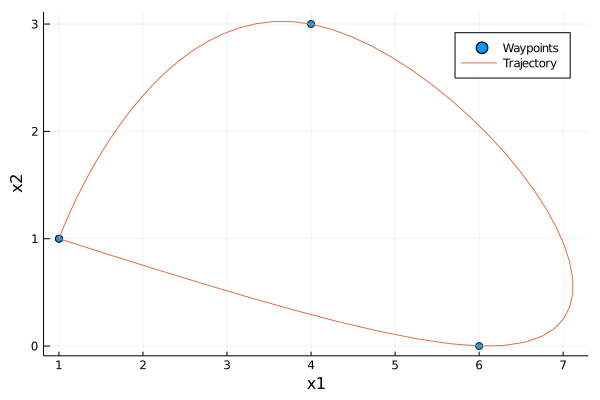

In [18]:
# Plot the results
scatter(p[1,:], p[2,:], label = "Waypoints")
plot!(x_opt[1], x_opt[2], label = "Trajectory")
xlabel!("x1")
ylabel!("x2")